# CS4035 - Cyber Data Analytics
## Lab 2 

### Submit on brightspace (zip file with the name Group_xx.zip)
(i) This jupyter file completed with code, plots, figures and report for each question. Additional plots and figures can be created for explanation before the end of each main question. Lab 2 contains 7 main questions, including the bonus. Write the code or explanation below each sub question. For the explantions, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.
(ii) A PDF or a Word report for the assignment. Create a report from the plots, figures, tables and the write-up that you provide in this jupyter file. The report will be used as a proof for page limit. 
(iii) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 


## Group Number :

## Student 1 
### Name :
### ID :

## Student 2
### Name :
### ID :

## Readme - Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

In [1]:
import numpy as np
import pandas as pd 

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf


from tqdm import tqdm
import itertools

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

from jupyterthemes import jtplot
jtplot.style('grade3')

import warnings
warnings.filterwarnings('ignore')

## 1. Familiarization task – 1 A4

### 1a. Plot visualizations 

In [2]:
# load the data
training_data = pd.read_csv('./SWaT_train.csv')
testing_data = pd.read_csv('./SWaT_test.csv')

training_signals = training_data.drop(columns=[' Timestamp', 'Normal/Attack'])
training_label = training_data['Normal/Attack']
training_label = np.where(training_label.to_numpy() == 'Normal', 0, 1)

testing_signals = testing_data.drop(columns=['Unnamed: 0', ' Timestamp', 'Normal/Attack'])
testing_label = testing_data['Normal/Attack']
testing_label = np.where(testing_label.to_numpy() == 'Normal', 0, 1)

training_data.head()

,Timestamp,FIT101,LIT101,MV101,P101,P102,AIT201,AIT202,AIT203,FIT201,...,P501,P502,PIT501,PIT502,PIT503,FIT601,P601,P602,P603,Normal/Attack
0,22/12/2015 4:00:00 PM,2.470294,261.5804,2,2,1,244.3284,8.19008,306.101,2.471278,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
1,22/12/2015 4:00:01 PM,2.457163,261.1879,2,2,1,244.3284,8.19008,306.101,2.468587,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
2,22/12/2015 4:00:02 PM,2.439548,260.9131,2,2,1,244.3284,8.19008,306.101,2.467305,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
3,22/12/2015 4:00:03 PM,2.428338,260.2850,2,2,1,244.3284,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal
4,22/12/2015 4:00:04 PM,2.424815,259.8925,2,2,1,244.4245,8.19008,306.101,2.466536,...,1,1,10.02948,0.0,4.277749,0.000256,1,1,1,Normal


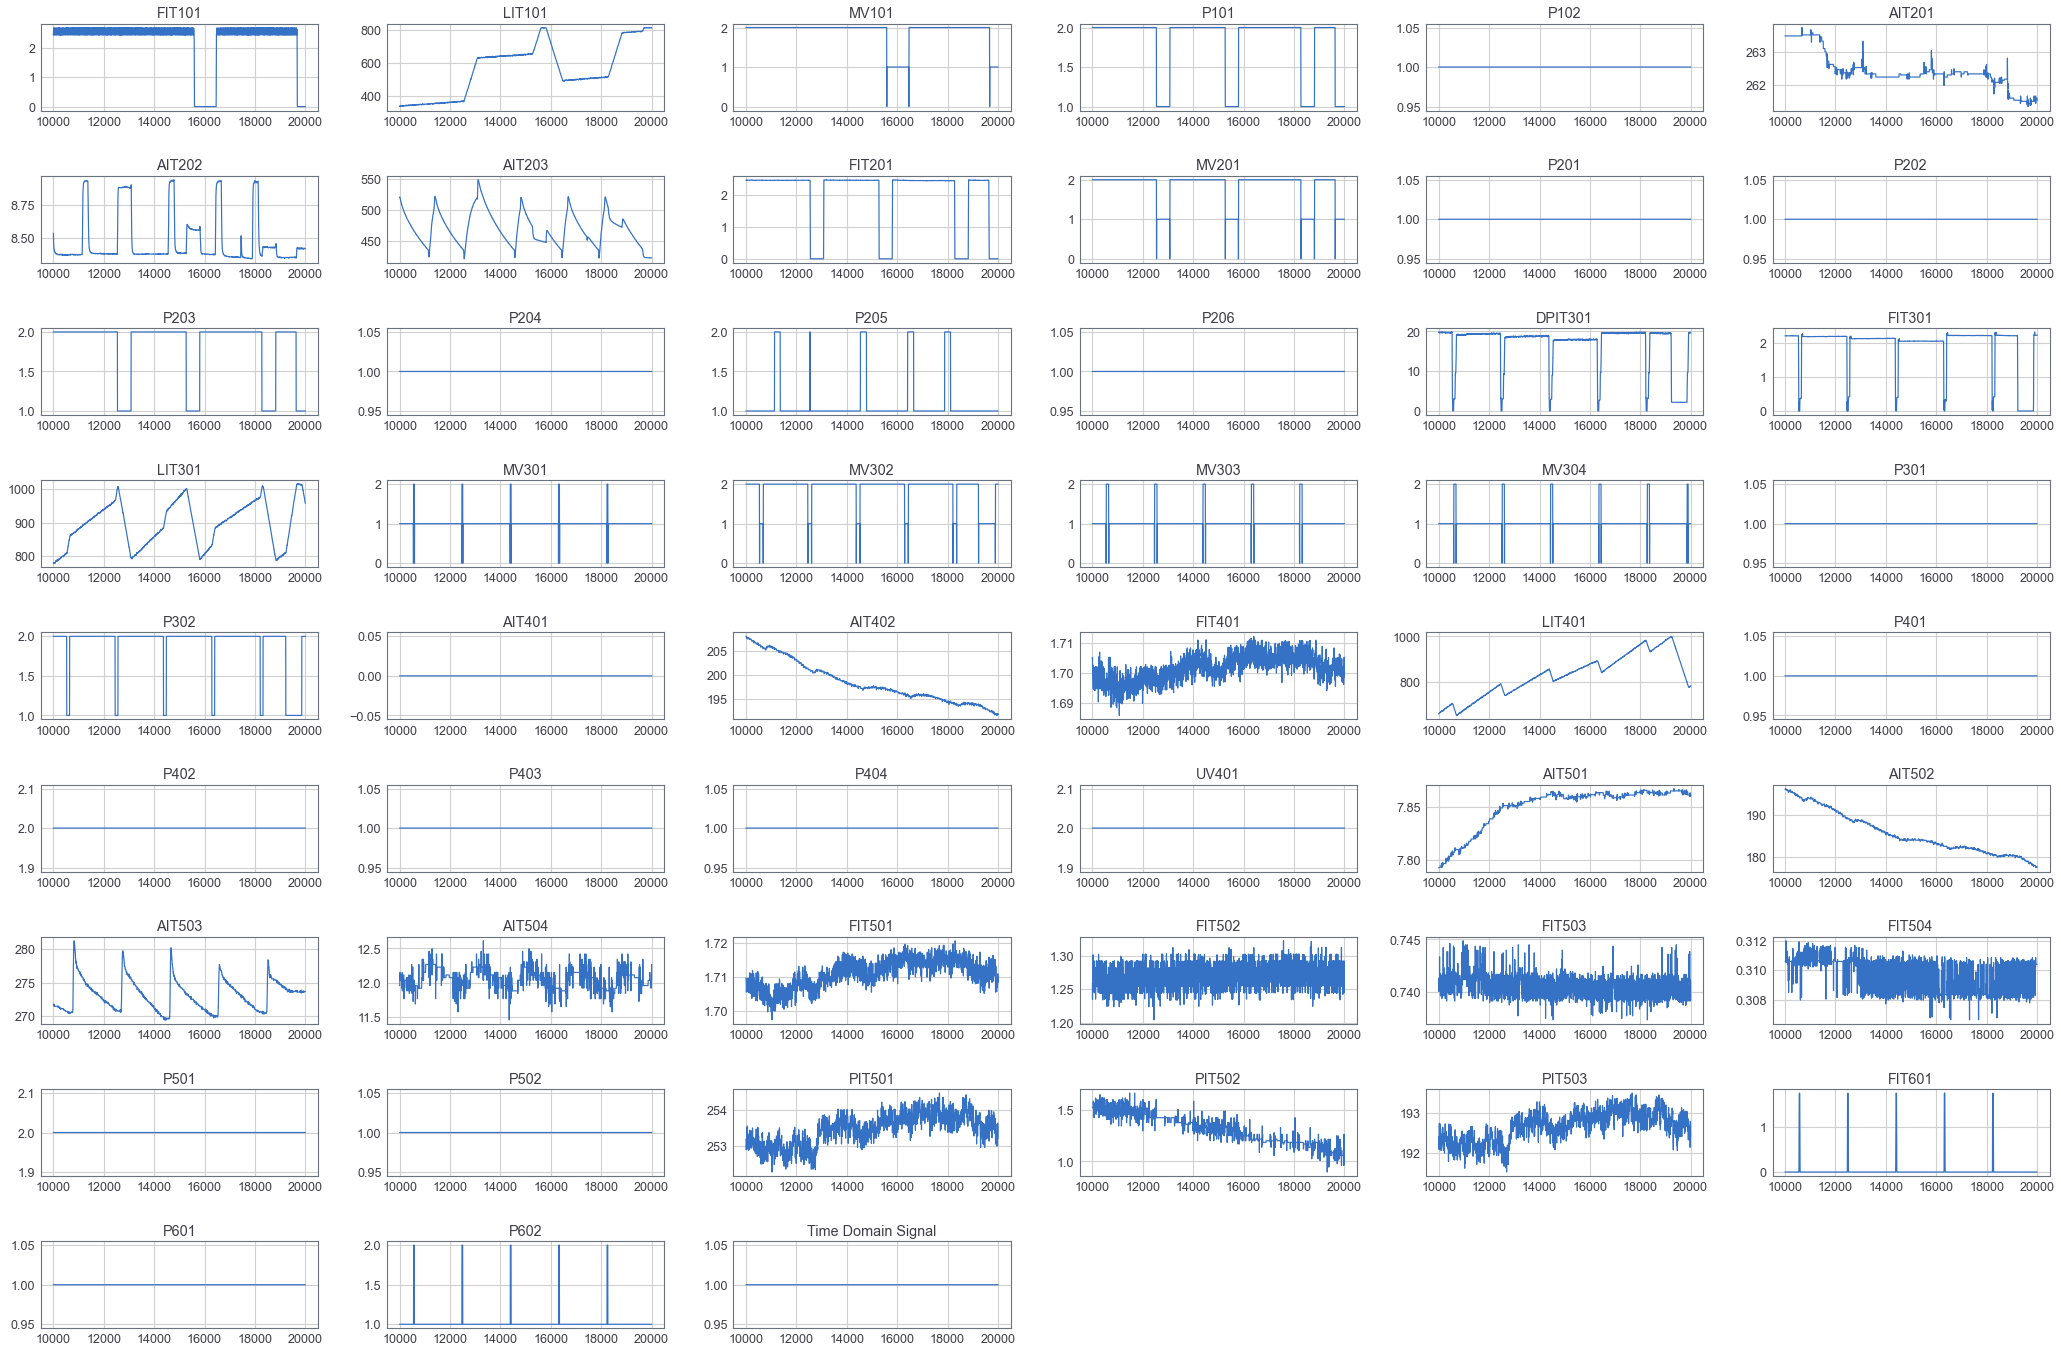

In [3]:
# to visualize patrial data
i = 1
plt.figure(figsize=(36, 24))
plt.subplots_adjust(wspace=0.25, hspace=0.75)
for col in list(training_signals.columns):
    plt.subplot(9, 6, i)
    training_signals.loc[10000:20000, col].plot()
    plt.title(col)
    i += 1
plt.title("Time Domain Signal")
plt.show()

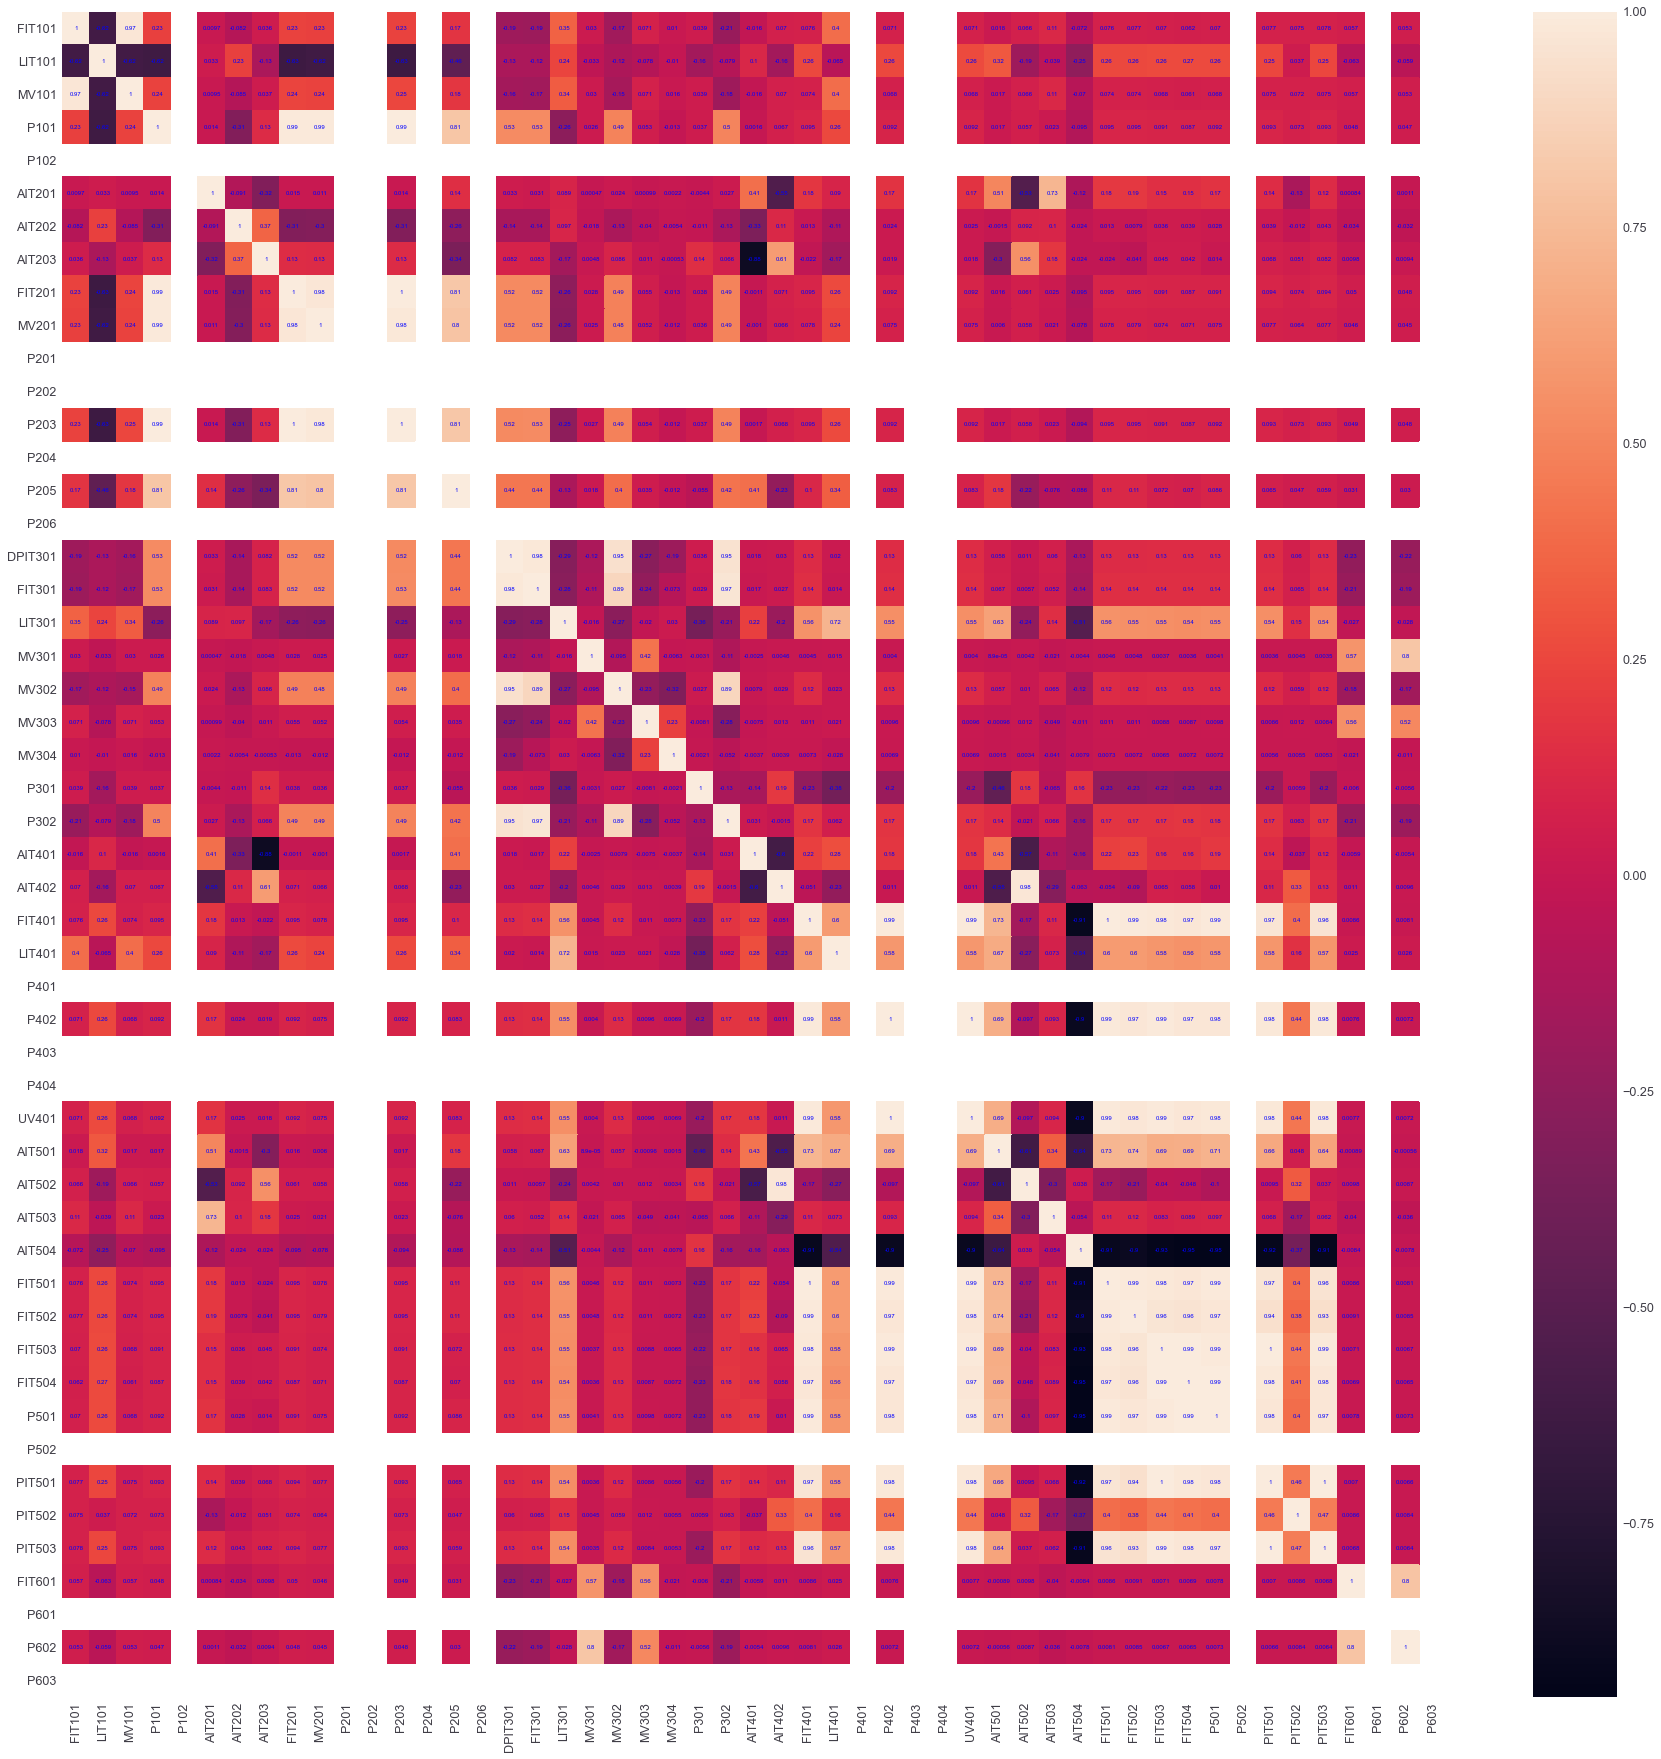

In [4]:
# to plot correlation matrix
corr = training_signals.corr()
plt.figure(figsize=(31,31))
sns.heatmap(corr, xticklabels=list(corr.columns), annot=True, yticklabels=list(corr.columns), annot_kws={'size':6,'color':'blue'})
plt.show()

In [5]:
def plot_signal(data,col,start=0,end=10000,title="",color="blue"):
	f,ax = plt.subplots(figsize=(22,3))
	f.suptitle(title)
	ax = sns.lineplot(data=data.loc[start:end,col],color=color)
	ax.set_xticks(range(start,end+1,5000))
	plt.show()	


Figure 3: perfectly correlated signals


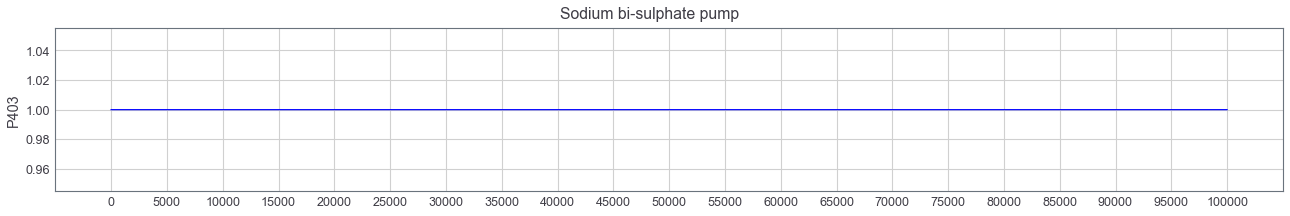

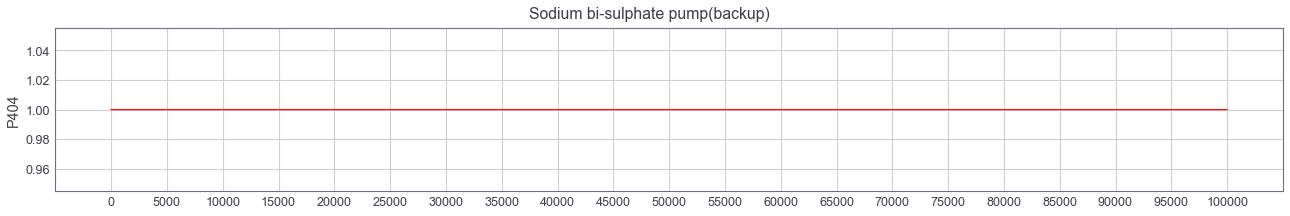


Figure 4: perfectly negatively correlated signals


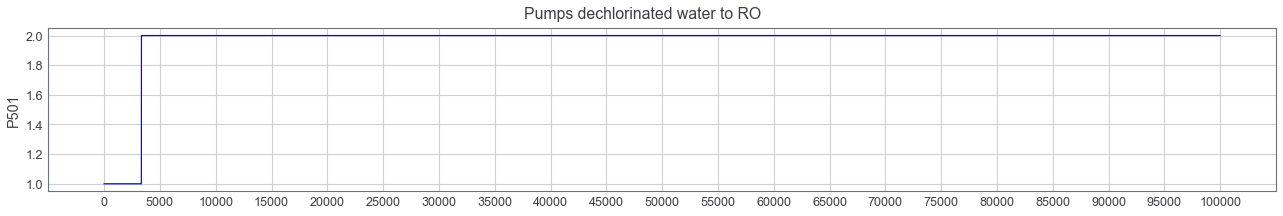

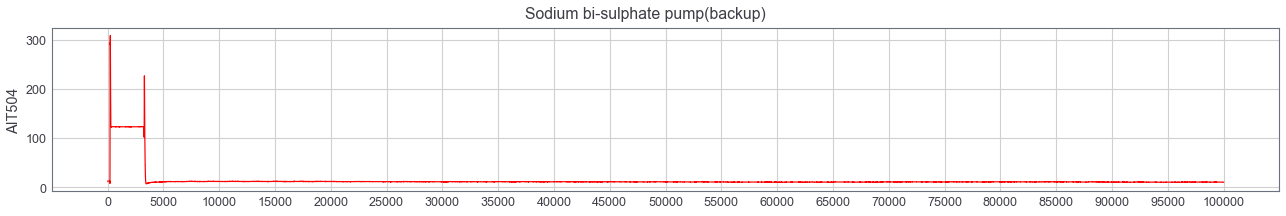

In [6]:
# Example of almost perfectly correlated signals
print("\nFigure 3: perfectly correlated signals")
plot_signal(training_signals,"P403",0,100000,"Sodium bi-sulphate pump","blue")
plot_signal(training_signals,"P404",0,100000,"Sodium bi-sulphate pump(backup)","red")

# Example of almost perfectly negatively correlated signals
print("\nFigure 4: perfectly negatively correlated signals")
plot_signal(training_signals,"P501",0,100000,"Pumps dechlorinated water to RO","blue")
plot_signal(training_signals,"AIT504",0,100000,"Sodium bi-sulphate pump(backup)","red")

In [7]:
# sliding_window for the forcast
def sliding_window(df, window_size, stride=1):
    N = np.floor((len(df) - window_size)/stride).astype(np.int)+1
    return_window = []
    for i in range(N):
        return_window.append(df[i*stride:i*stride+window_size])
    return np.array(return_window)

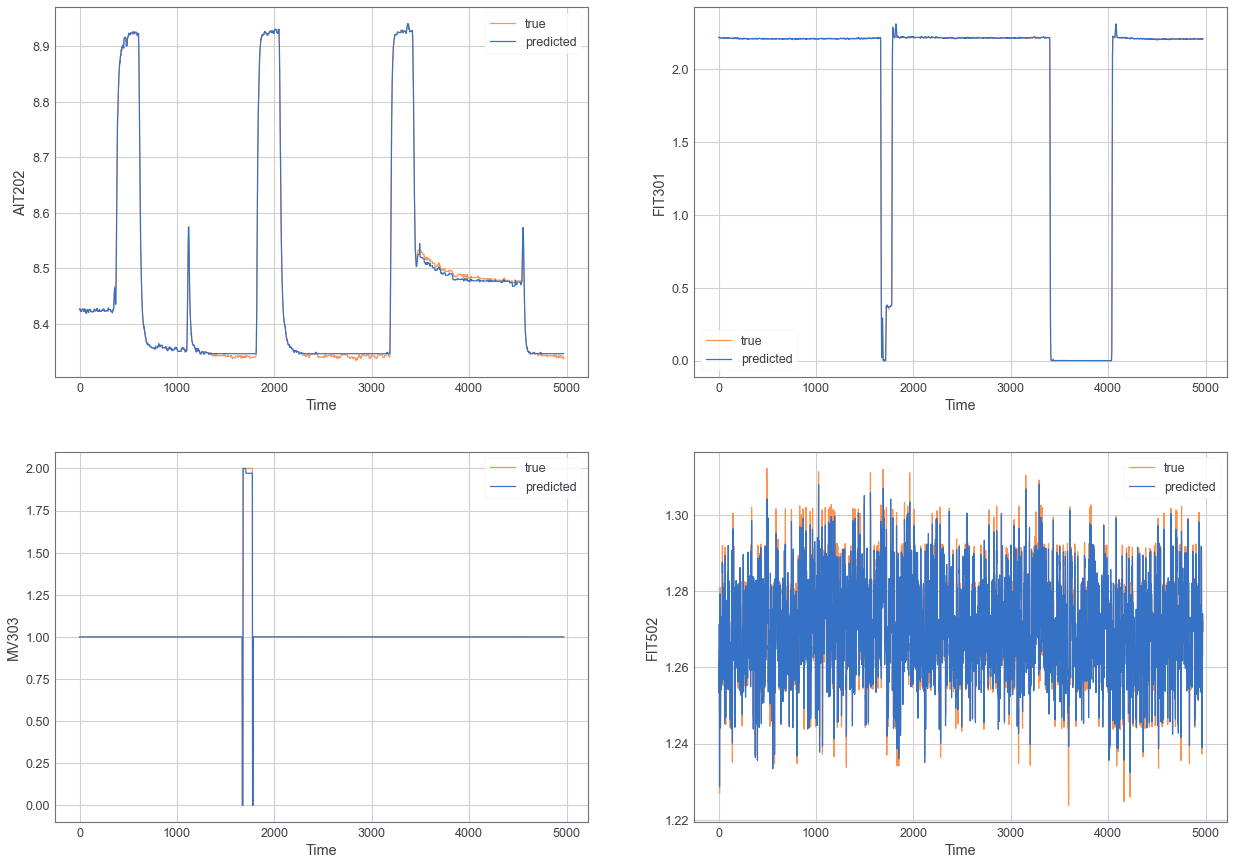

In [6]:
# applying sliding_window for ['AIT202', 'FIT301', 'MV303', 'FIT502']
columns_pred = ['AIT202', 'FIT301', 'MV303', 'FIT502']

window_size = 30
plt.figure(figsize=(21, 15))
i = 1
for col in columns_pred:
    # training
    training_col = training_signals.loc[10000:20000, col].copy()
    sw_training_col = sliding_window(
        training_col, window_size=window_size, stride=1)
    col_x = sw_training_col[:, :window_size-1]
    col_y = sw_training_col[:, window_size-1]
    rfr = RandomForestRegressor().fit(col_x, col_y)

    # testing
    tesing_col = training_signals.loc[20000:25000, col].copy()
    sw_testing_col = sliding_window(
        tesing_col, window_size=window_size, stride=1)
    test_col_x = sw_testing_col[:, :window_size-1]
    test_col_y = sw_testing_col[:, window_size-1]
    test_col_pred = rfr.predict(test_col_x)

    # plotting
    plt.subplot(2, 2, i)
    i += 1
    plt.plot(np.arange(len(test_col_y)), test_col_y, color='y')
    plt.plot(np.arange(len(test_col_pred)), test_col_pred, color='b')
    plt.legend(['true', 'predicted'])
    plt.xlabel('Time')
    plt.ylabel(col)
plt.show()

### 1b. Answers to the three questions

## 2. LOF task – 1/2 A4 – Individual

In [7]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_y = testing_label.copy()

### 2a. Plot LOF scores

In [8]:
# # uncomment it if you want to run it, but it is very time-consuming

# """
# The opposite LOF of the training samples. The higher, the more normal. 
# Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1), 
# while outliers tend to have a larger LOF score.

# The local outlier factor (LOF) of a sample captures its supposed ‘degree of abnormality’. 
# It is the average of the ratio of the local reachability density of a sample 
# and those of its k-nearest neighbors.
# """

# lofs = [] # for storing negative_outlier_factor_ score
# tpr = [] # for storing true positive rate
# fnr = [] # for storing false positive rate

# for nn in np.arange(1,121, 2):
#     lof = LocalOutlierFactor(n_neighbors=nn, algorithm='kd_tree', leaf_size=100,
#                              metric='minkowski', p=1, contamination="auto", novelty=True, n_jobs=-1)
#     lof.fit(train_X)
#     lofs.append(lof.negative_outlier_factor_)

#     y_pred = lof.predict(test_X)
#     y_pred = y_pred == -1 # 0 <- -1, 0s/-1s are normal

#     tn, fp, fn, tp = confusion_matrix(test_y, y_pred).ravel()
#     tpr.append(tp)
#     fnr.append(fn)
    
#     print(">" , end='')

In [9]:
tpr = np.loadtxt('./LOFtps.txt')
fnr = np.loadtxt('./LOFfns.txt')

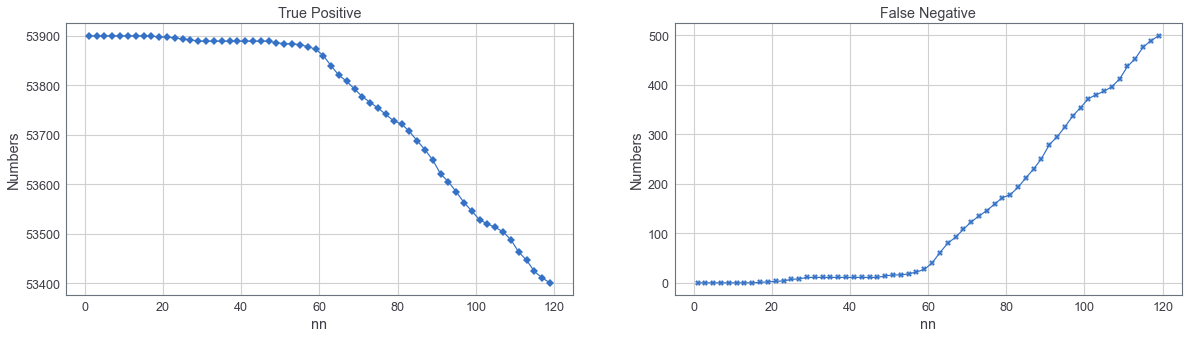

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(np.arange(1,121, 2), tpr, '-D')
plt.title('True Positive')
plt.xlabel('nn')
plt.ylabel('Numbers')
plt.subplot(122)
plt.plot(np.arange(1,121, 2), fnr, '-X')
plt.title('False Negative')
plt.xlabel('nn')
plt.ylabel('Numbers')
plt.show()

### 2b. Analysis and answers to the questions

## 3. PCA task – 1/2 A4 – Individual

In [11]:
train_X = training_signals.copy()
train_y = training_label.copy()
test_X = testing_signals.copy()
test_y = testing_label.copy()

### 3a. Plot PCA residuals

In [12]:
# decide n_components
# to normalize the training data
normalizer = Normalizer().fit(train_X)
train_X_norm = normalizer.transform(train_X)

res = []
for n_components in np.arange(5, 25+1):
    # pca
    pca = PCA(n_components=n_components).fit(train_X_norm)

    # pca forward transform
    train_X_pca = pca.transform(train_X_norm)

    # pca backward transform
    train_X_invpca = pca.inverse_transform(train_X_pca)

    # compute residual
    res.append(np.linalg.norm(train_X_norm - train_X_invpca, ord=2, axis=1))
    
    print('>', end='')

>>>>>>>>>>>>>>>>>>>>>

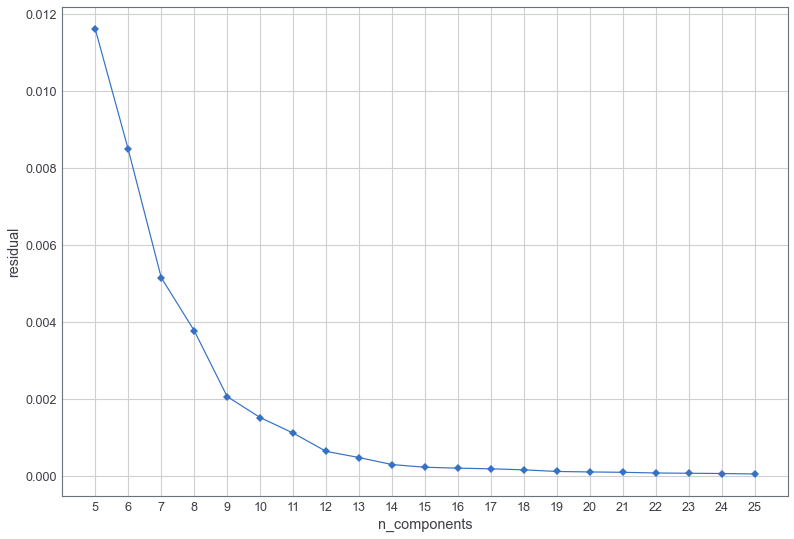

In [13]:
# plot residual ~ n_components
plt.figure(figsize=(13, 9))
plt.plot(np.arange(5, 25+1), np.mean(res, axis=1), '-D')
plt.xticks(ticks=np.arange(5, 25+1))
plt.ylabel('residual')
plt.xlabel('n_components')
plt.show()

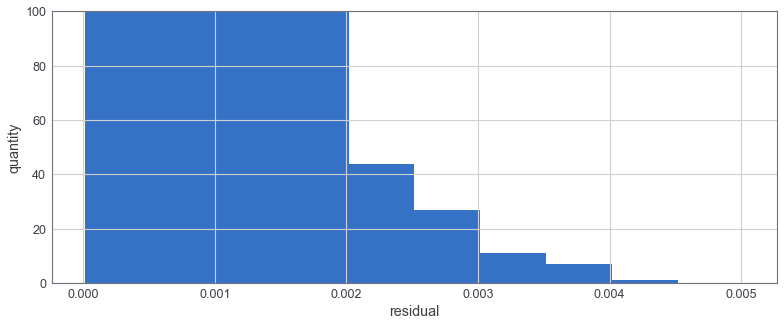

In [14]:
# box-plot to visualize the distribution
plt.figure(figsize=(13, 5))
plt.hist(res[12], range=[np.min(res[12]), np.max(res[12])+0.001])
plt.xlabel('residual')
plt.ylabel('quantity')
plt.ylim([0,100])
plt.show()

In [15]:
n_components = 12
threshold = 0.004

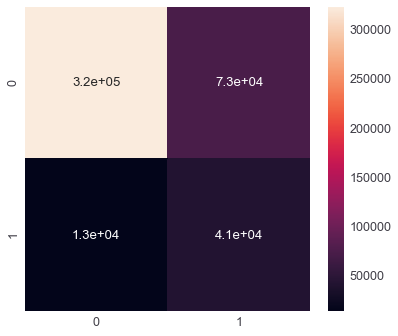

In [16]:
# build pca
pca = PCA(n_components=n_components).fit(train_X_norm)

# normalize testing data
test_X_norm = Normalizer().transform(test_X)

# forward pca
test_X_pca = pca.transform(test_X_norm)

# backward pca
test_X_invpca = pca.inverse_transform(test_X_pca)

# prediction
test_pred = np.linalg.norm(test_X_norm-test_X_invpca, ord=2, axis=1) > threshold

# confusion matrix
cm = confusion_matrix(test_y, test_pred)
f = sns.heatmap(cm, annot=True)

### 3b. Analysis and answers to the questions

## 4. ARMA task – 1/2 A4 - Individual

In [17]:
train_X = training_signals['AIT504'].copy()
train_y = training_label.copy()
test_X = testing_signals['AIT504'].copy()
test_y = testing_label.copy()

### 4a. Print relevant plots and/or metrics to determine the parameters.

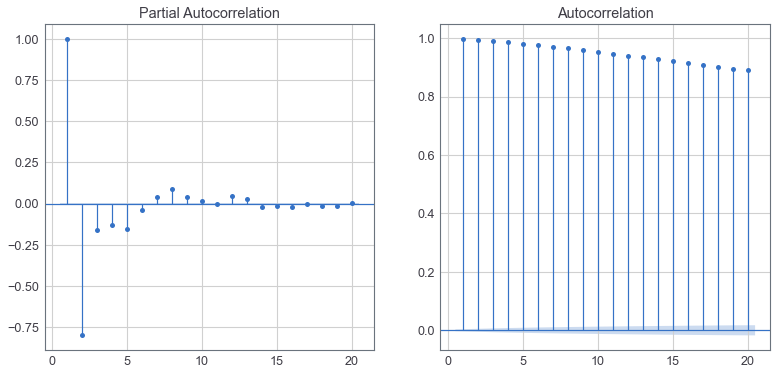

In [18]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
plot_acf(test_X, lags=20, zero=False, ax=ax2)
plot_pacf(train_X, lags=20, zero=False, ax=ax1)
plt.show()

In [22]:
# select the model with lowest aic
aic = np.inf 
order = None
arima = None

p_range = range(1,4) 
q_range = range(1,3) 
# d = 0 if (adfuller(train_X[12000:16000])[1] < 0.05) else 1
d_range = range(0, 2)

for i in p_range:
    for j in q_range:
        for d in d_range:
                temp_model = ARIMA(train_X[12000:16000], order=(i,d,j)).fit()
                temp_aic = temp_model.aic
                if temp_aic < aic:
                    aic = temp_aic
                    best_order = (i, d, j)
                    arima = temp_model
            

print('Best Order:', best_order)

Best Order: (2, 1, 1)


### 4b. Plots to study the detected anomalies

                               SARIMAX Results                                
Dep. Variable:                 AIT504   No. Observations:               496800
Model:                 ARIMA(2, 1, 1)   Log Likelihood              526614.620
Date:                Sat, 22 May 2021   AIC                       -1053221.240
Time:                        14:53:18   BIC                       -1053176.776
Sample:                             0   HQIC                      -1053208.649
                             - 496800                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1714      0.000   7121.301      0.000       1.171       1.172
ar.L2         -0.2272      0.000  -1596.361      0.000      -0.227      -0.227
ma.L1         -0.5754      0.000  -4308.333      0.0

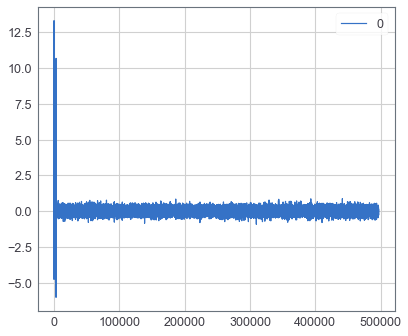

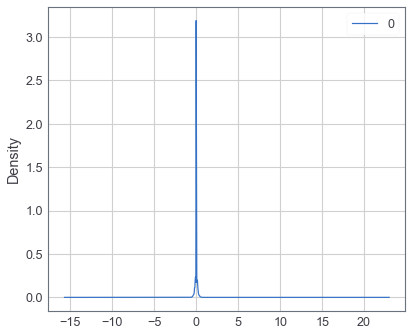

                   0
count  496800.000000
mean        0.000025
std         0.085742
min        -6.031940
25%        -0.000003
50%         0.000000
75%         0.000003
max        13.320519


In [23]:
series = train_X
# fit model
model = ARIMA(series, order=best_order)
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals.describe())

In [24]:
train, test = train_X[10000:20000].values, test_X[11410-250:11410+50].values
label = test_y[11410-250:11410+50]
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=best_order)
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))

Test RMSE: 0.092


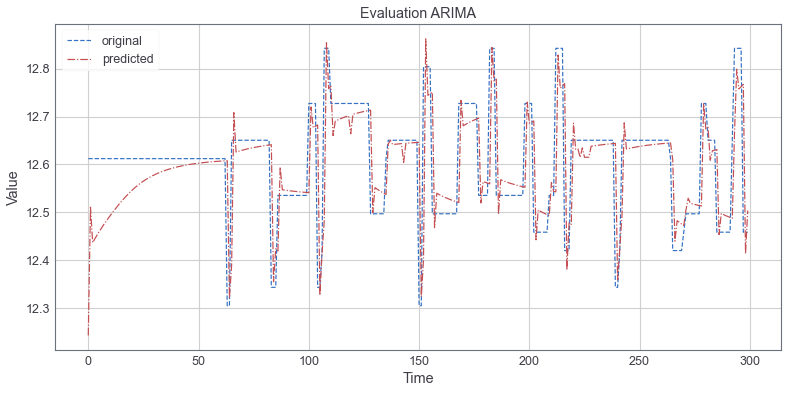

In [25]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.figure(figsize=(13,6))
plt.plot(test, "--b")
plt.plot(predictions, '-.r')
plt.title("Evaluation ARIMA")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend(['original', 'predicted'])
plt.show()

### 4c. Analysis and answers to the questions

## 5. N-gram task – 1/2 A4 - Individual

In [110]:
def dicretize_data(signal, discretize_groups):
    # Initiliaze arrays
    label_classes = []
    step_sizes = []

    # Compute min and max value of signal to compute the stepsize
    min_value = min(signal)
    max_value = max(signal)
    step_size = (max_value - min_value) / discretize_groups

    bins = []
    bins.append(min_value)
    # Create bins
    for i in range(discretize_groups):
        label_classes.append(i)
        bins.append(bins[i] + step_size)

    # Use digitize method to discretize the signal
    return np.digitize(signal, bins), bins

### 5a. Visualise discretization

In [112]:
# discretize
def plot_discretize(ngram_signal):
    train_X = training_signals[ngram_signal].copy()
    train_y = training_label.copy()
    test_X = testing_signals[ngram_signal].copy()
    test_y = testing_label.copy()
    plt.figure(figsize=(21,9))
    plt.title("Training Set")
    plt.subplot(121)
    plt.plot(np.unique(train_X,return_counts=True)[0], np.unique(train_X,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title("original")
    train_X_discrete, train_bins = dicretize_data(train_X, int(len(set(train_X))/100))
    plt.subplot(122)
    plt.plot(np.unique(train_X_discrete,return_counts=True)[0], np.unique(train_X_discrete,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title('after dicretized')

    plt.figure(figsize=(21,9))
    plt.title("Testing Set")
    plt.subplot(121)
    plt.plot(np.unique(test_X,return_counts=True)[0], np.unique(test_X,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title("original")
    test_X_discrete = np.digitize(test_X, train_bins)
    # train_X_discrete, test_bins = dicretize_data(test_X, int(len(set(test_X))/100))
    plt.subplot(122)
    plt.plot(np.unique(test_X_discrete,return_counts=True)[0], np.unique(test_X_discrete,return_counts=True)[1])
    plt.xlabel("values")
    plt.ylabel('counts')
    plt.title('after dicretized')
    plt.show()

In [113]:
ngram_signals = ['LIT101', 'LIT301', 'AIT202', 'AIT402', 'AIT503']

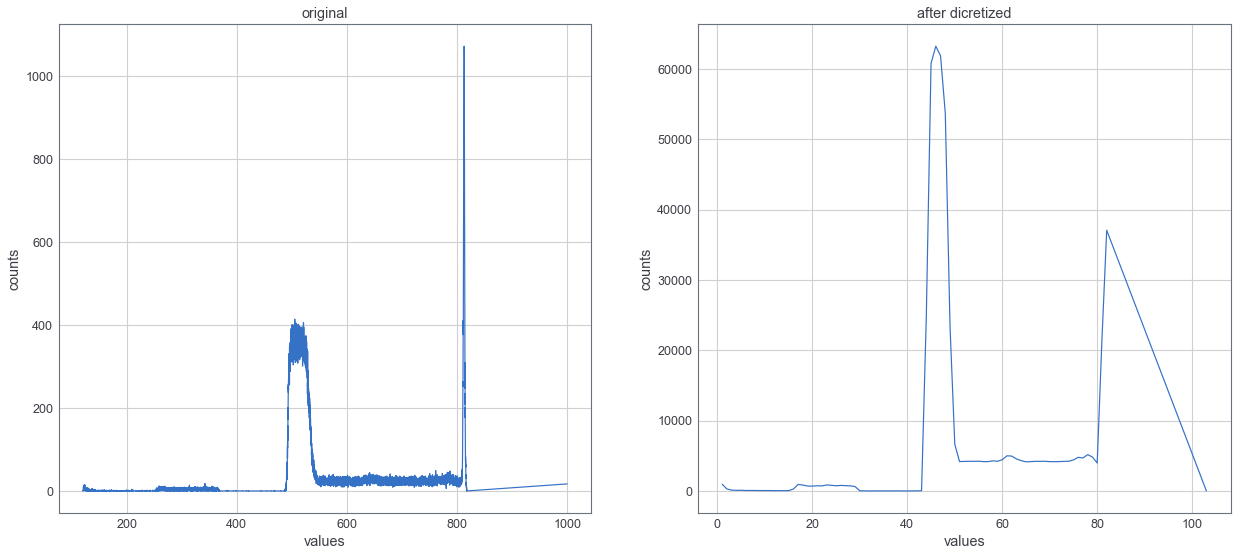

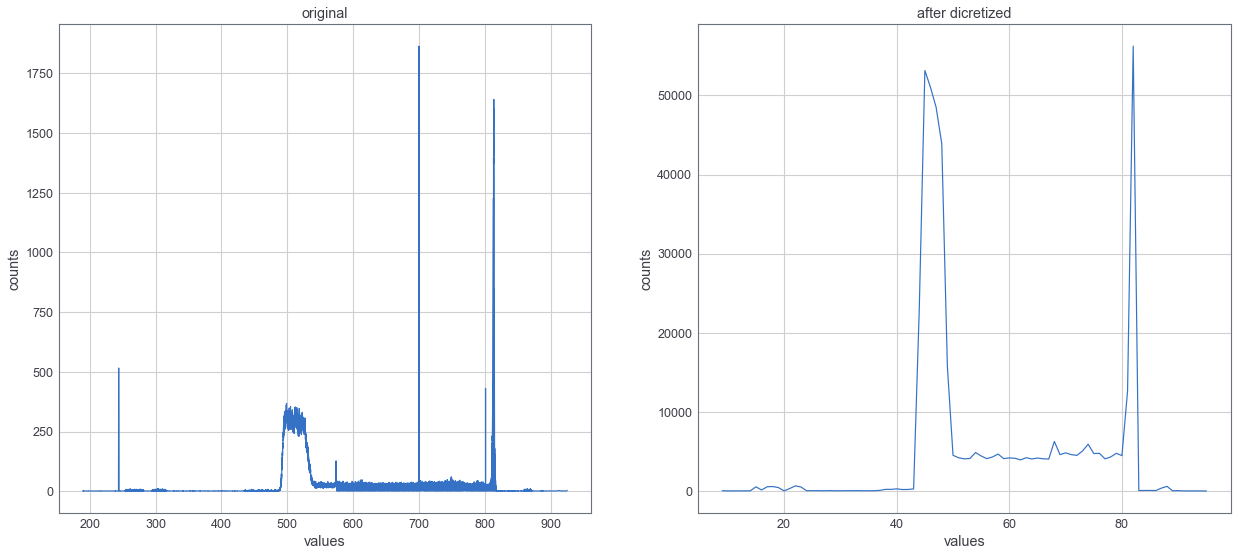

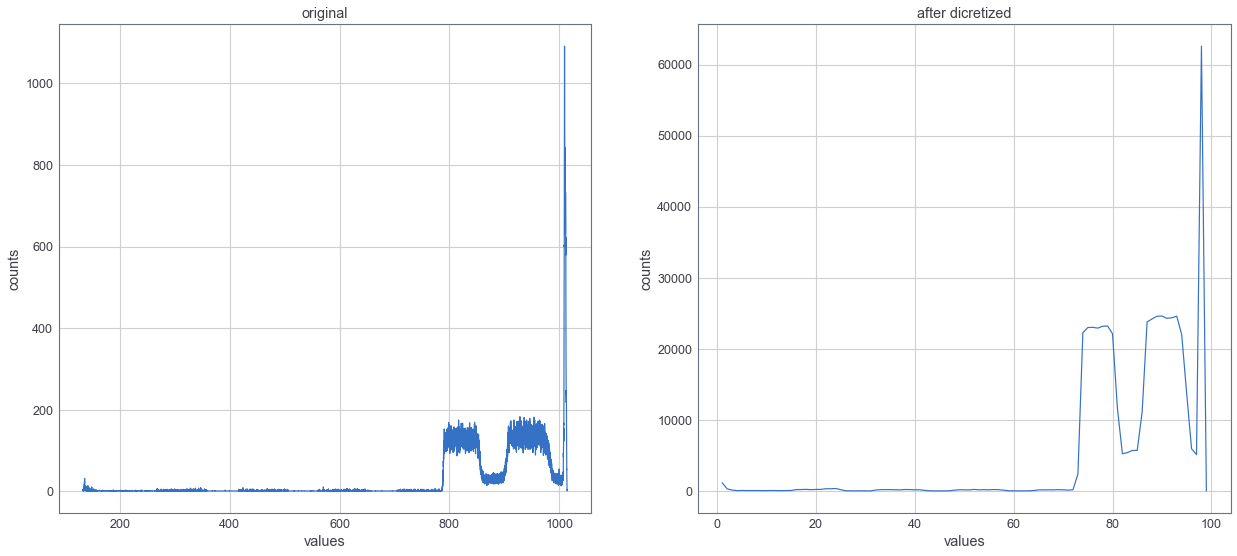

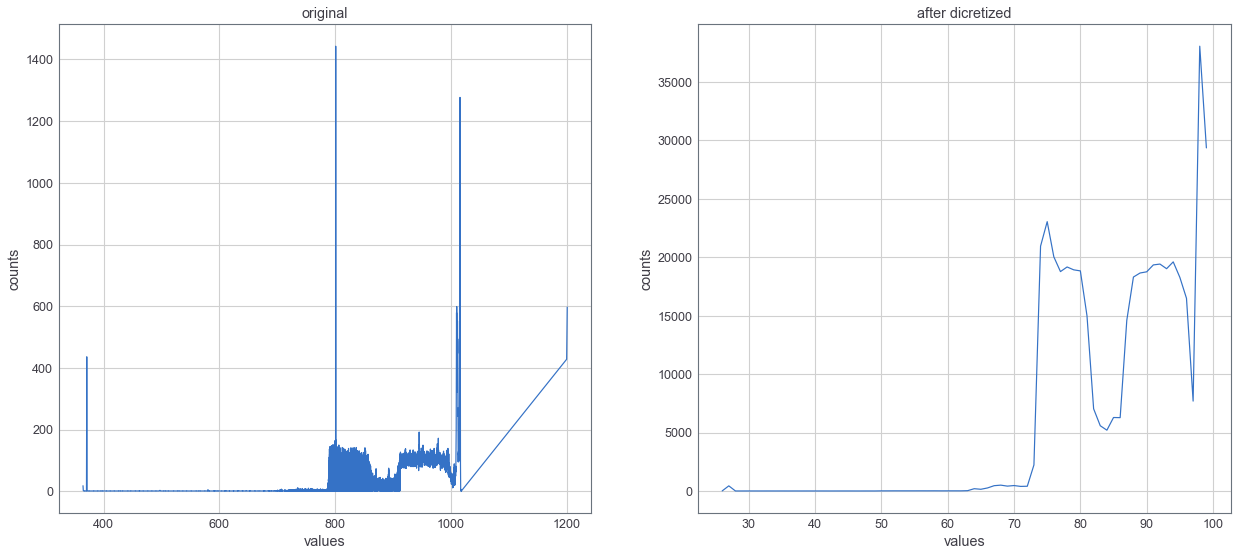

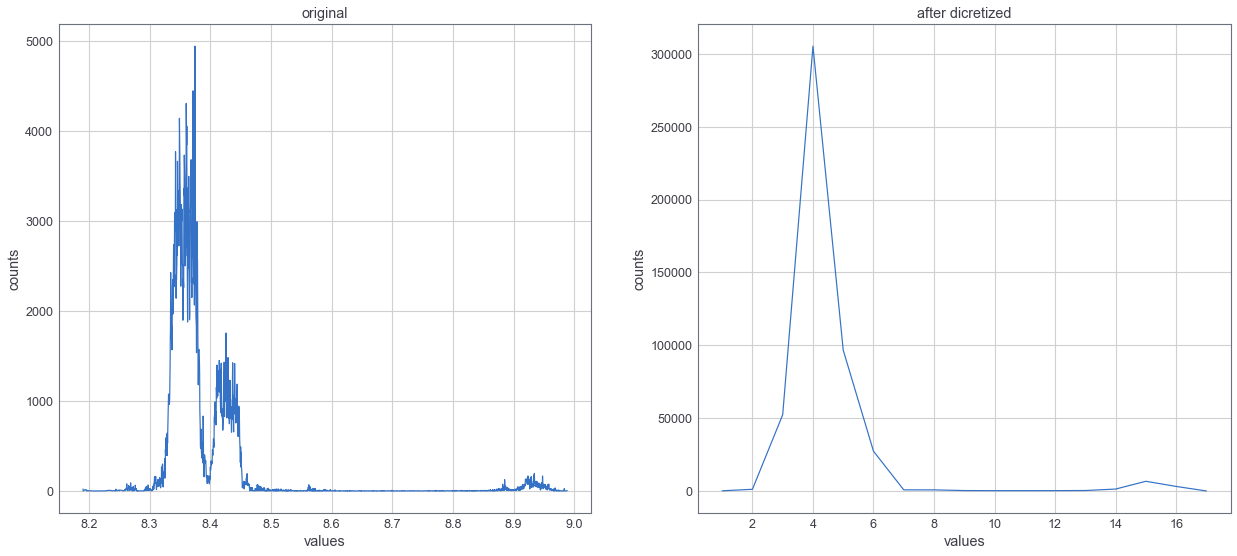

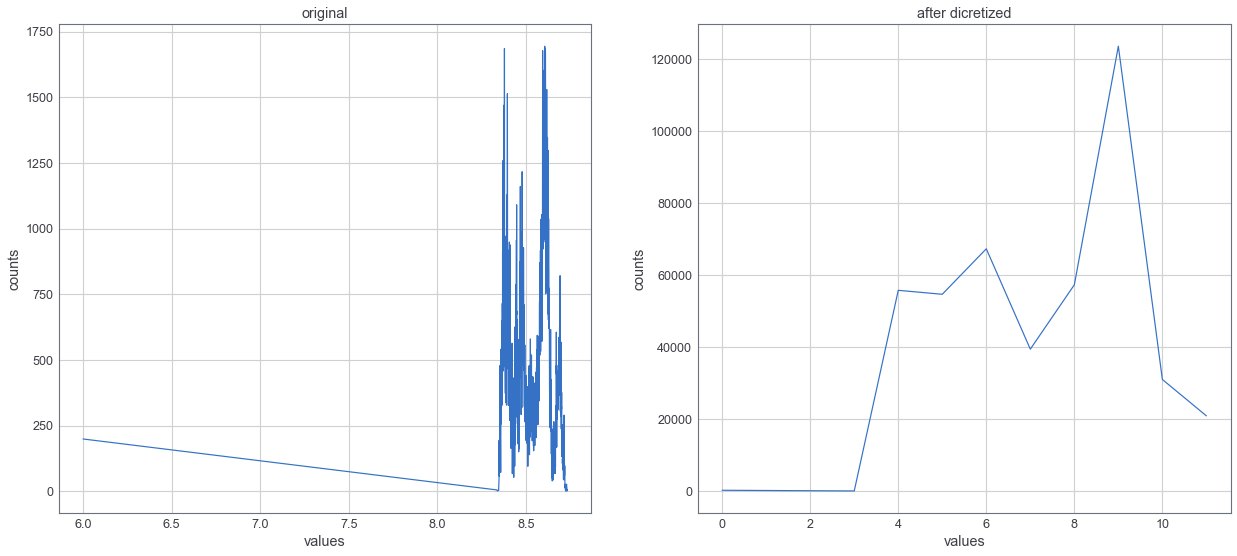

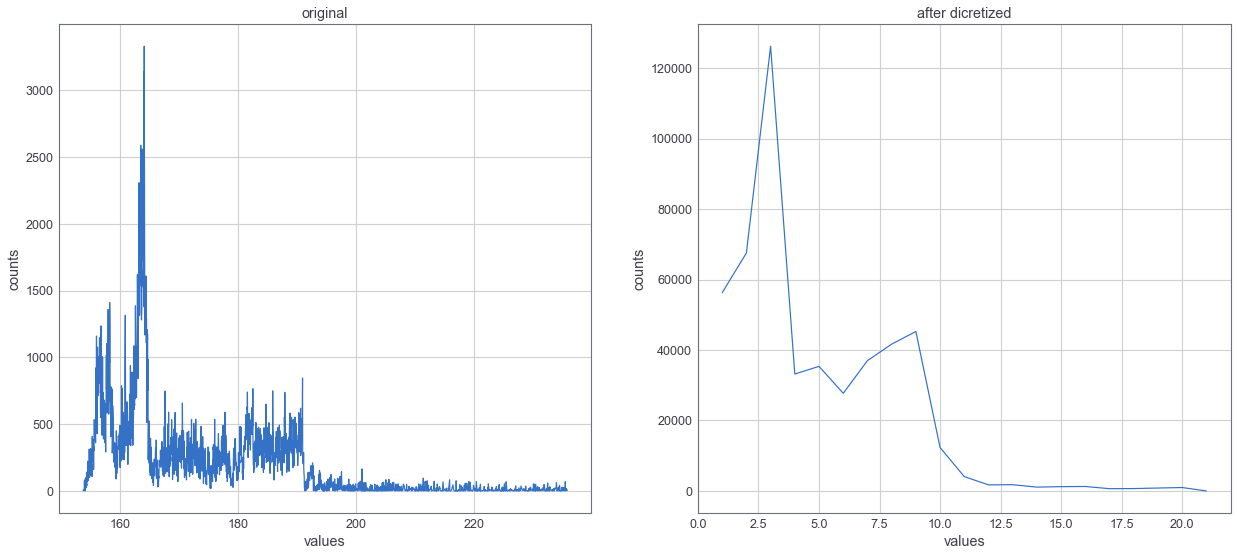

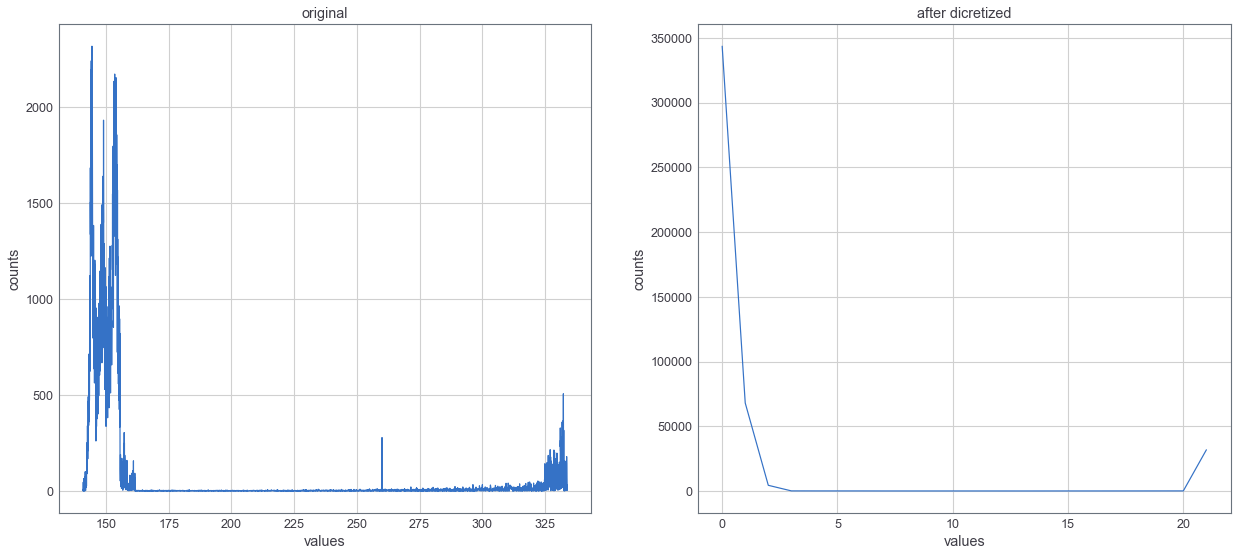

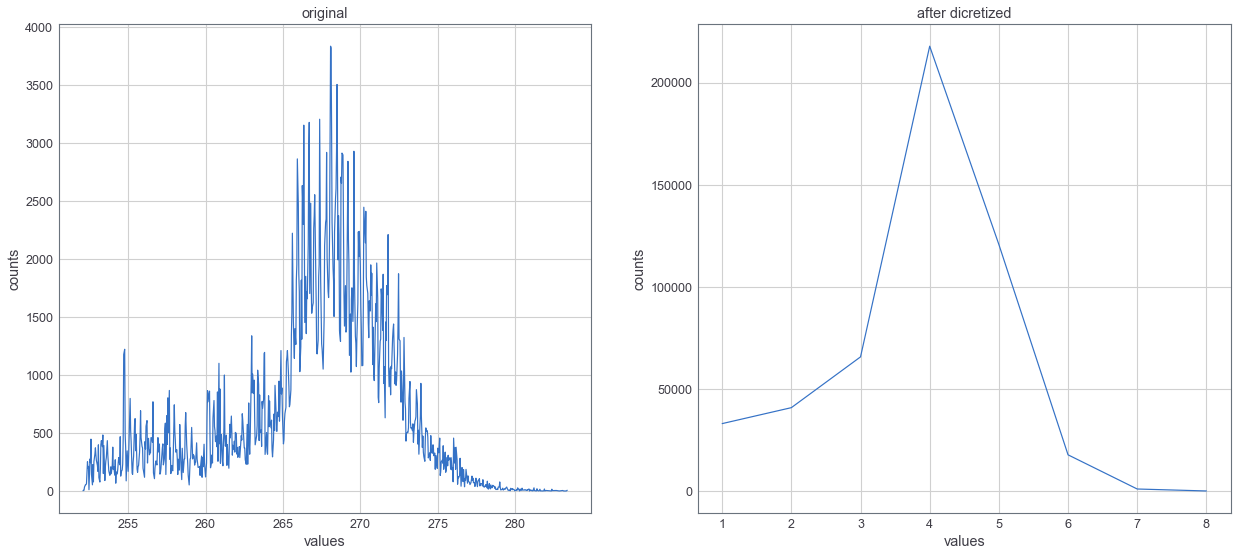

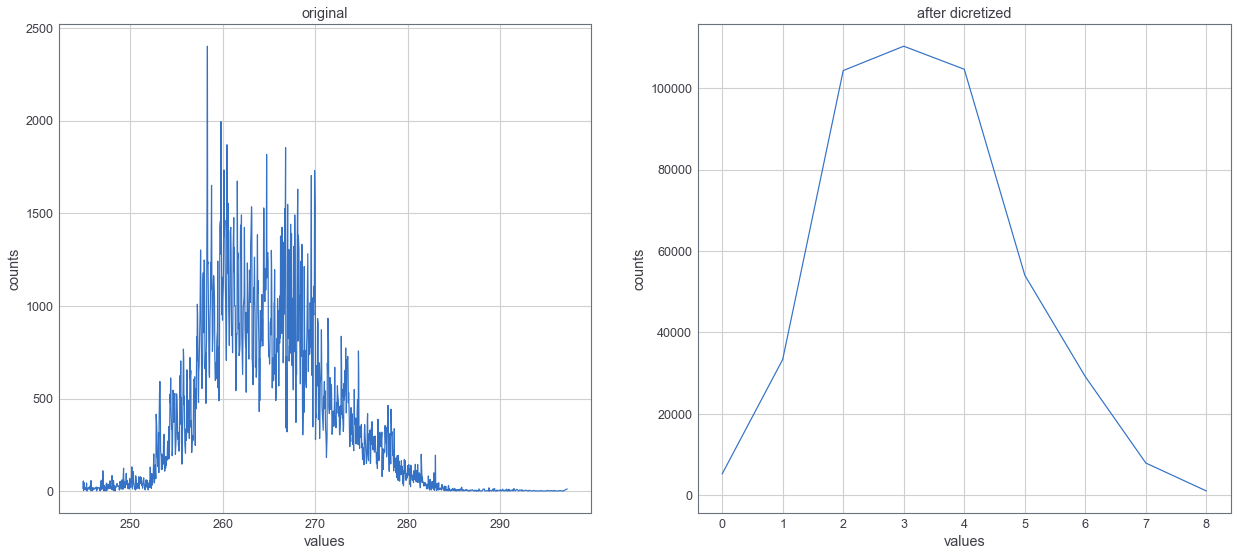

In [114]:
for ngram_signal in ngram_signals:
    plot_discretize(ngram_signal)

In [115]:
# Computes the occurences of each n-gram for the provided amount of sliding windows
def compute_ngram_matrix(signal, sliding_windows, n, stepsize):
    # Initialize matrix with amounnt of rows equal to the amount of sliding windows     
    matrix = pd.DataFrame(np.zeros(len(sliding_windows)))
    # Initialize counters     
    count_sliding_window = 0
    
    # For each sliding window length compute the occurences of the n-grams     
    for sliding_window in tqdm(sliding_windows):
        i = 0
        # Pick part of signal(depending on size of sliding window) until end of signal is reached
        while i + sliding_window <= len(signal):
            # Pick part of signal with size of sliding window
            cur_sliding_window = signal[i:i + sliding_window]
            j = 0
            # Loop through part of signal and count the n-grams until end is reached             
            while j + n <= len(cur_sliding_window):
                # Current n-gram                 
                cur_ngram = cur_sliding_window[j:j + n]
                cur_ngram_string = ''
                # Create string value of n-gram                 
                for k in cur_ngram:
                    cur_ngram_string += str(k)
                # Check if matrix already contains a column for the specific n-gram, if so, add 1 to the correct cell.
                # If not, create a column and set                  
                if cur_ngram_string not in matrix.columns:
                    matrix.loc[count_sliding_window, cur_ngram_string] = 1
                else:
                    if np.isnan(matrix.loc[count_sliding_window, cur_ngram_string]):
                        matrix.loc[count_sliding_window, cur_ngram_string] = 1
                    else:
                        matrix.loc[count_sliding_window, cur_ngram_string] += 1
                j += 1
            i += stepsize
        count_sliding_window += 1
    # To avoid NAN's, replace all NAN's with 0      
    matrix = matrix.fillna(0)
    # Delete first column(was there just for initialization of the dataframe)     
    matrix = matrix.drop(matrix.columns[0], axis=1)
    
    # Normalize all rows by their total value
    matrix = matrix.div(matrix.sum(axis=1), axis=0)
    return matrix

In [118]:
def get_ngram_matrix(ngram_signal):
    # Intialize hyperparameters
    n = 10
    stepsize = 5
    sliding_windows = [400]

    # Compute the matrix where the row represents the size of the sliding windows and the columns the N-grams.
    # The cells in the matrix represent the occurence of the N-gram in that sliding window
    # train_matrices = {}
    # test_matrices = {}

    # For simplicity and to avoid enormous runtime, it is only done for signal
    # for signal in signals:
    train_X = training_signals[ngram_signal].copy()
    train_y = training_label.copy()
    test_X = testing_signals[ngram_signal].copy()
    test_y = testing_label.copy()
    train_X_discrete, train_bins = dicretize_data(train_X, int(len(set(train_X))/100))
    
    train_ngram_matrix = compute_ngram_matrix(train_X_discrete, sliding_windows, n, stepsize)
    # save train_ngram_matrix
    train_ngram_matrix.to_csv('./ngram/train_ngram_matrix'+ngram_signal+'.csv')
    
    test_X_discrete, test_bins = dicretize_data(test_X, int(len(set(test_X))/100))
    test_ngram_matrix = compute_ngram_matrix(
    test_X_discrete, sliding_windows, n, stepsize)
    # save test_ngram_matrix
    test_ngram_matrix.to_csv('./ngram/test_ngram_matrix'+ngram_signal+'.csv')


In [ ]:
# # it is very time consuming, we comment this for you to avoid training, you can directly load trained data from file ./ngramdata/train_ngram_matrix
# for ngram_signal in ngram_signals:
#     get_ngram_matrix(ngram_signal)

In [119]:
# Returns the L most frequent n-grams in the data
def get_most_freq_ngrams(data, threshold):
    # Count the total occurence of each N-gram 
    top_L = data.sum(axis=0)
    # Sort the occurences of each n-gram in descending order
    top_L = top_L.sort_values(ascending=False)
    # Compute the total occurences for normalization
    sum_all_values = top_L.sum()
    # Normalize
    top_L = top_L/sum_all_values
    # Pick top X n-grams
    top_L = top_L[0:threshold].index
    return top_L

In [120]:
def get_top_unsimilar_ngrams(train_ngram_matrix, test_ngram_matrix):
    # Threshold to which top the new instances are compared
    L_threshold = 50
    # Dictonary where key is the n-gram and value the closest distance
    # to a n-gram from the top X n-grams of the training data    
    best_matches = {}
    # Get top L n-grams(which occurs the most in the training data)     
    top_L = get_most_freq_ngrams(train_ngram_matrix, L_threshold)
    # Compute similarity using frequencies and check to which top L class it belongs
    for ngram in test_ngram_matrix.columns:
        # Set max distance         
        min_distance = 1
        # Get frequencies of test n-gram         
        ngram_test = test_ngram_matrix.loc[:,ngram]
        # Find n-gram that is closest to new instance         
        for top_ngram in top_L:
            # Get frequencies             
            cur_top_ngram = train_ngram_matrix.loc[:,top_ngram]
            # compute cosine distance 
            cos_sim = np.dot(ngram_test, cur_top_ngram) / (np.linalg.norm(ngram_test)*np.linalg.norm(cur_top_ngram))
            cos_distance = 1 - cos_sim
            # Save smallest distance              
            if cos_distance < min_distance:
                min_distance = cos_distance
                best_match = top_ngram               
        best_matches[ngram] = min_distance
    # Sort on distance (descending)         
    test_n_gram_similarities = {k: v for k, v in sorted(best_matches.items(), key=lambda item: item[1], reverse=True)}
    # Print top 25 most not matching n-gram     
    top_n_grams_not_similiar = list(itertools.islice(test_n_gram_similarities.items(), 0, 25))
    print(top_n_grams_not_similiar)
    return(top_n_grams_not_similiar)

In [121]:
def plot_anomaly(signal, indexes_of_signal, start, end):
    # y-values     
    y = np.array(signal[start:end])
    list_xvalues = list(range(start,end)) 
    x = np.array(list_xvalues)

    # Anamolies should be marked red
    threshold = 15
    plt.figure(figsize=(21,9))
    # Plot the line
    plt.plot(x, y, color='blue')
    plt.title("Anomaly detection for signal " + str(signal))
    plt.xlabel("Time")
    plt.ylabel("Value of signal")
    plt.scatter(x[np.in1d(x,indexes_of_signal)], y[np.in1d(x,indexes_of_signal)], color='red')

In [122]:
def get_discretize_test(ngram_signal):
    train_X_discrete, train_bins = dicretize_data(
        training_signals[ngram_signal].copy(), int(len(set(training_signals[ngram_signal].copy()))/100) )
    test_X_discrete = np.digitize(testing_signals[ngram_signal], train_bins)
    return test_X_discrete


def show_ngram_result(signals):
    for ngram_signal in signals:
        print(ngram_signal)
        train_ngram_matrix = pd.read_csv('./ngramdata/train_ngram_matrix_' + ngram_signal + '.csv')
        test_ngram_matrix = pd.read_csv('./ngramdata/test_ngram_matrix_' + ngram_signal + '.csv')
        train_ngram_matrix.drop(columns="Unnamed: 0", inplace=True)
        test_ngram_matrix.drop(columns="Unnamed: 0", inplace=True)
        res = get_top_unsimilar_ngrams(train_ngram_matrix, test_ngram_matrix)
        # Discretize data for each signal
        dicretize_test = [get_discretize_test(ngram_signal)]
        string_res = []
        # Create signal string containing the discretized data
        for disc_data in discretized_data:
            string = ''
            for i in disc_data:
                string += str(i)
            string_res.append(string)

        # Save the cosine distances of the different signals
        results = [res]
        count = 0
        plot_data = []

        # Find the ngram indexes in the test signal
        for result in results:
            match_ngrams = []
            for tup in result:
                found_indexes = [i for i in range(
                    len(string_res[count])) if string_res[count].startswith(tup[0], i)]
                for i in found_indexes:
                    match_ngrams.append(i + n - 1)
            indexes_of_signal = sorted(set(match_ngrams))
            plot_data.append(indexes_of_signal)
            count += 1

        # Define range to plot, dependent on the indexes of the anomalies
        plot_anomaly(testing_signals[ngram_signal], plot_data[0], 0, len(
            testing_signals[ngram_signal]))

LIT101
[('48484848484848484848', 0.0), ('48484848484848484849', 0.0), ('48484848484848484949', 0.0), ('48484848484848494949', 0.0), ('48484848484849494949', 0.0), ('48484848484949494949', 0.0), ('48484848494949494949', 0.0), ('48484849494949494949', 0.0), ('48484949494949494949', 0.0), ('48494949494949494949', 0.0), ('49494949494949494949', 0.0), ('49494949494949494948', 0.0), ('49494949494949494848', 0.0), ('49494949494949484848', 0.0), ('49494949494948484848', 0.0), ('49494949494848484848', 0.0), ('49494949484848484848', 0.0), ('49494948484848484848', 0.0), ('49494848484848484848', 0.0), ('49484848484848484848', 0.0), ('48484848484848484948', 0.0), ('48484848484848494848', 0.0), ('48484848484849484848', 0.0), ('48484848484948484848', 0.0), ('48484848494848484848', 0.0)]
LIT301
[('92929292929292929292', 0.0), ('92929292929292929293', 0.0), ('92929292929292929393', 0.0), ('92929292929292939393', 0.0), ('92929292929293939393', 0.0), ('92929292929393939392', 0.0), ('92929292939393939292'

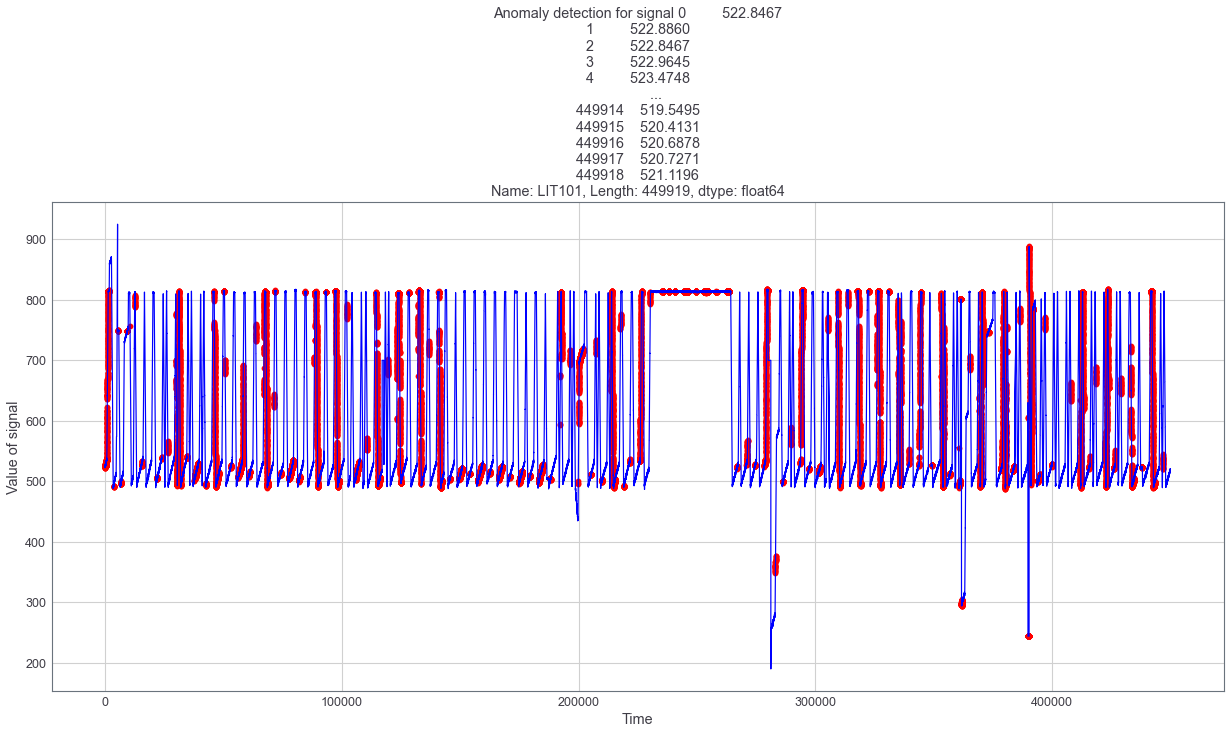

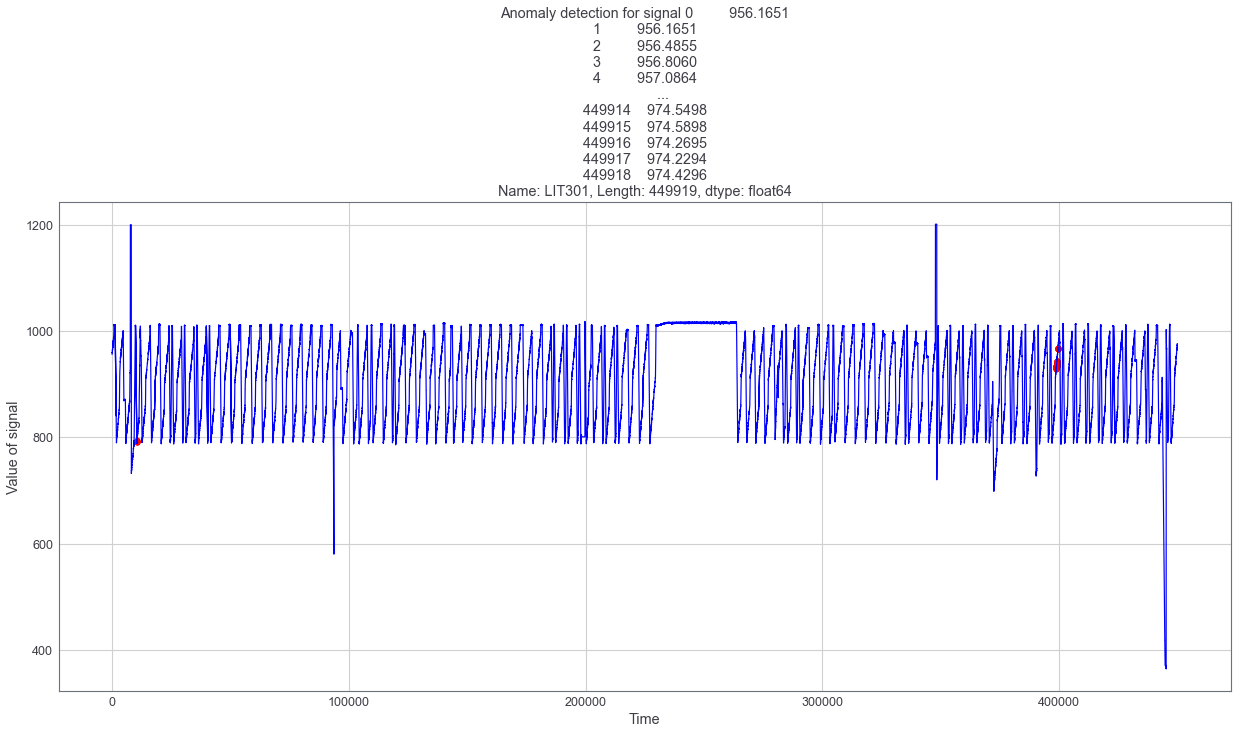

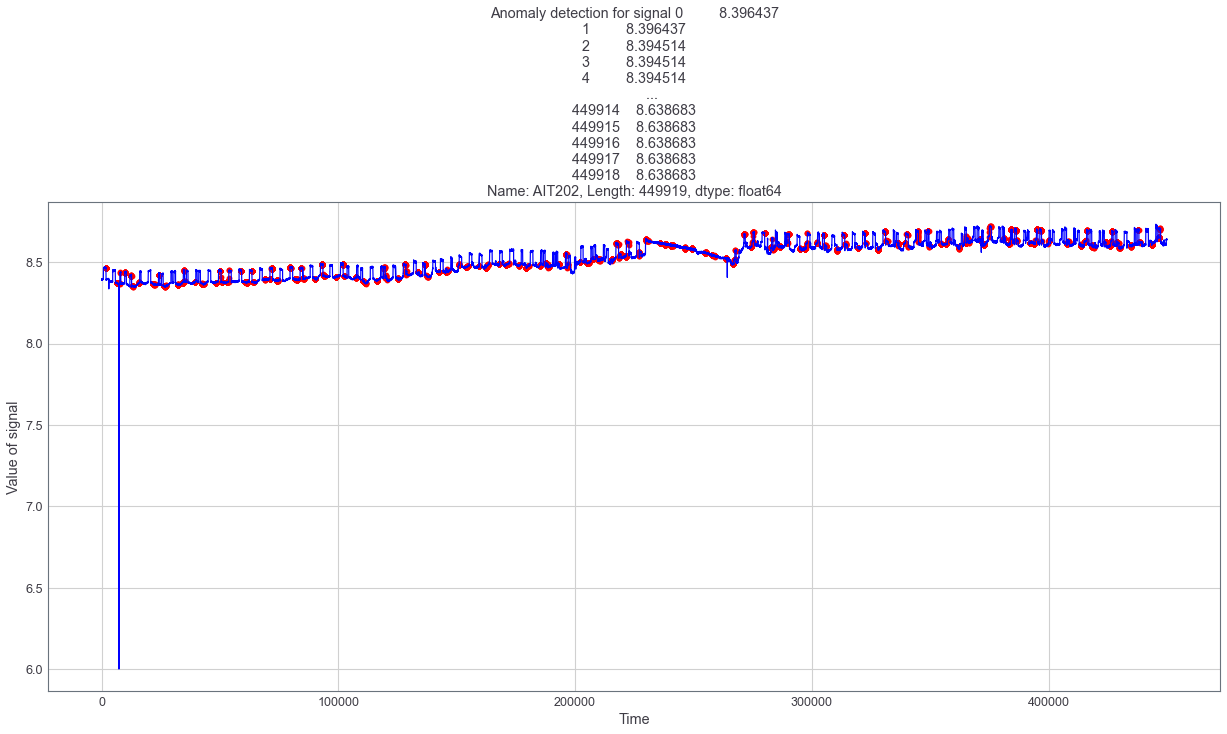

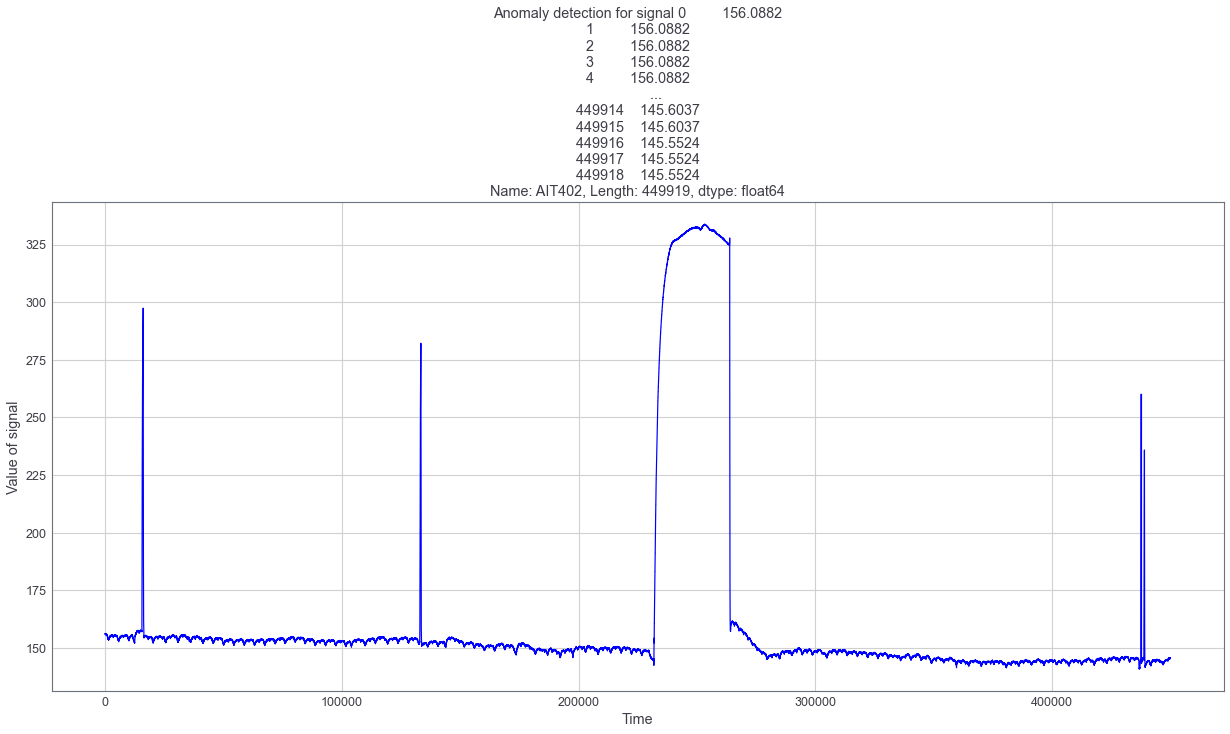

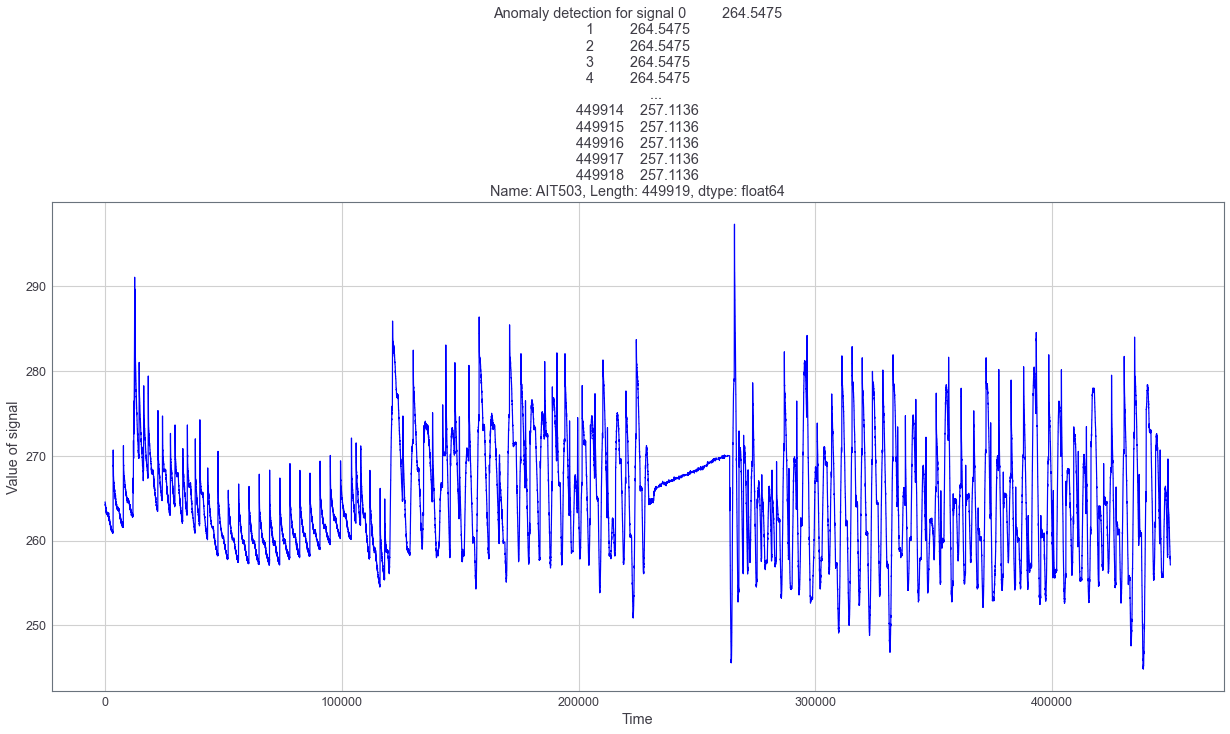

In [123]:
show_ngram_result(ngram_signals)


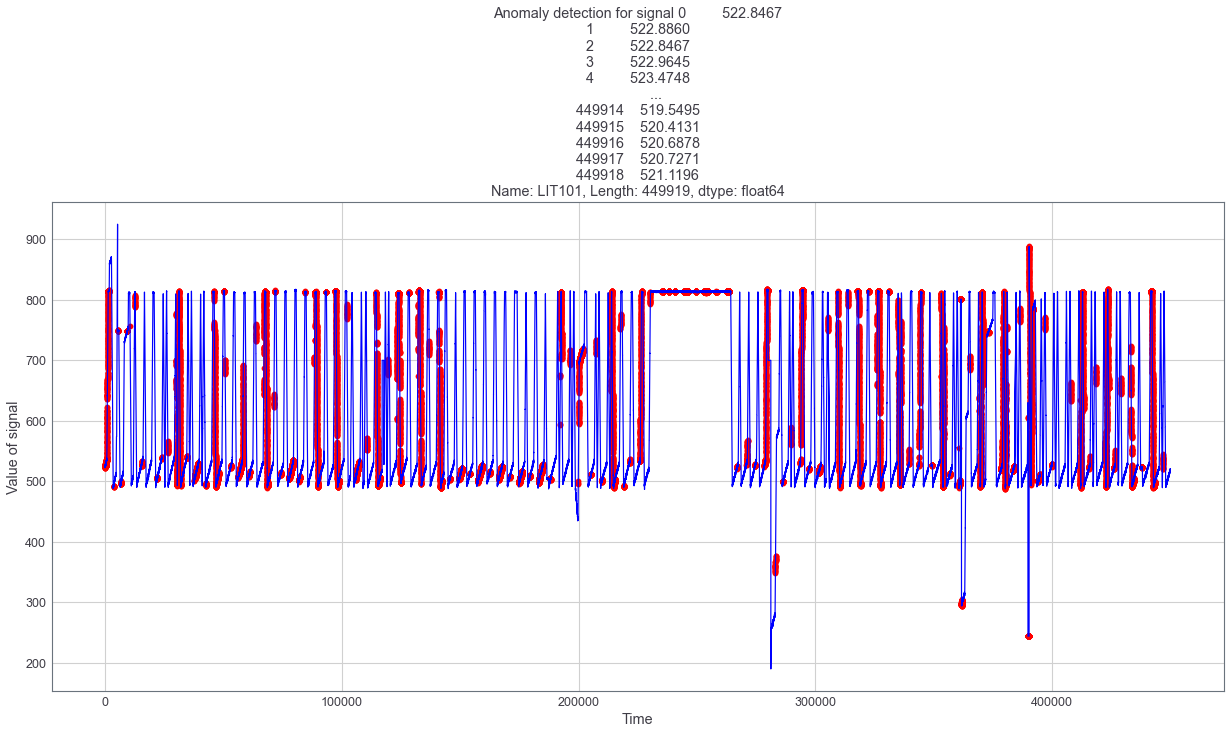

In [79]:
# # To show results of different signals, I precomputed the cosine distances of the ngrams to avoid long runtime
# res_LIT301 = top_n_grams_not_similiar

# # Create dicretized signal
# signals = ['LIT101']
# signal_tot = []

# # Discretize data for each signal
# dicretize_test_LIT301 = test_X_discrete

# # Save dicretized data in array
# discretized_data = [dicretize_test_LIT301]
# string_res = []

# # Create signal string containing the discretized data 
# for disc_data in discretized_data:
#     string = ''
#     for i in disc_data:
#         string +=  str(i)
#     string_res.append(string)
    
# # Save the cosine distances of the different signals 
# results = [res_LIT301]

# count = 0
# plot_data = []

# # Find the ngram indexes in the test signal
# for result in results:
#     match_ngrams = []
#     for tup in result:
#         found_indexes = [i for i in range(len(string_res[count])) if string_res[count].startswith(tup[0], i)]
#         for i in found_indexes:
#             match_ngrams.append(i + n - 1)
#     indexes_of_signal = sorted(set(match_ngrams))
#     plot_data.append(indexes_of_signal)
#     count += 1

# # Define range to plot, dependent on the indexes of the anomalies
# plot_anomaly(test_X, plot_data[0], 0, len(test_X))

### 5b. Analysis and answers to the questions. Also provide relevant plots.

## 6.Comparision task 1 A4 - Individual

### 6a. Use the given guidelines and provide a comparision of the above implemented methods.

## 7. Bonus Task 1 A4

### 7a. Provide implementation and analysis.